<a href="https://colab.research.google.com/github/ankursrj/Cat-and-dog-classificattion/blob/main/Cat_and_dog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

--2024-01-04 10:17:46--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 184.25.248.114, 2600:1417:3f:138a::317f, 2600:1417:3f:1388::317f
Connecting to download.microsoft.com (download.microsoft.com)|184.25.248.114|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘kagglecatsanddogs_5340.zip’

kagglecatsanddogs_5 100%[===================>] 786.67M   231MB/s    in 3.4s    

2024-01-04 10:17:50 (234 MB/s) - ‘kagglecatsanddogs_5340.zip’ saved [824887076/824887076]



# New Section

In [ ]:
!unzip kagglecatsanddogs_5340.zip

Streaming output truncated to the last 5000 lines.
  inflating: PetImages/Dog/5500.jpg  
  inflating: PetImages/Dog/5501.jpg  
  inflating: PetImages/Dog/5502.jpg  
  inflating: PetImages/Dog/5503.jpg  
  inflating: PetImages/Dog/5504.jpg  
  inflating: PetImages/Dog/5505.jpg  
  inflating: PetImages/Dog/5506.jpg  
  inflating: PetImages/Dog/5507.jpg  
  inflating: PetImages/Dog/5508.jpg  
  inflating: PetImages/Dog/5509.jpg  
  inflating: PetImages/Dog/551.jpg   
  inflating: PetImages/Dog/5510.jpg  
  inflating: PetImages/Dog/5511.jpg  
  inflating: PetImages/Dog/5512.jpg  
  inflating: PetImages/Dog/5513.jpg  
  inflating: PetImages/Dog/5514.jpg  
  inflating: PetImages/Dog/5515.jpg  
  inflating: PetImages/Dog/5516.jpg  
  inflating: PetImages/Dog/5517.jpg  
  inflating: PetImages/Dog/5518.jpg  
  inflating: PetImages/Dog/5519.jpg  
  inflating: PetImages/Dog/552.jpg   
  inflating: PetImages/Dog/5520.jpg  
  inflating: PetImages/Dog/5521.jpg  
  inflating: PetImages/Dog/5522.jpg  

In [ ]:
import pandas as pd
import torch
from torchvision import datasets, models, transforms
from torch import nn, optim
import os

In [ ]:
input_path = []
label = []

for class_name in os.listdir("PetImages"):
    for path in os.listdir("PetImages/"+class_name):
        if class_name == 'Cat':
            label.append(0)
        else:
            label.append(1)
        input_path.append(os.path.join("PetImages", class_name, path))
print(input_path[2565], label[2565])

PetImages/Dog/3916.jpg 1


In [ ]:
df = pd.DataFrame()
df["images"] = input_path
df["lable"] = label
df = df.sample(frac=1).reset_index()
df.head()

,index,images,lable
0,12491,PetImages/Dog/2910.jpg,1
1,11061,PetImages/Dog/3021.jpg,1
2,20498,PetImages/Cat/1415.jpg,0
3,18186,PetImages/Cat/9529.jpg,0
4,18992,PetImages/Cat/10832.jpg,0


In [ ]:
for i in df['images']:
    if '.jpg' not in i:
        print(i)

PetImages/Cat/Thumbs.db
PetImages/Dog/Thumbs.db


In [ ]:
import PIL
l = []
for image in df['images']:
    try:
        img = PIL.Image.open(image)
    except:
        l.append(image)
l

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


['PetImages/Cat/666.jpg',
 'PetImages/Cat/Thumbs.db',
 'PetImages/Dog/11702.jpg',
 'PetImages/Dog/Thumbs.db']

In [ ]:
# delete db files
df = df[df['images']!='PetImages/Dog/Thumbs.db']
df = df[df['images']!='PetImages/Cat/Thumbs.db']
df = df[df['images']!='PetImages/Cat/666.jpg']
df = df[df['images']!='PetImages/Dog/11702.jpg']
len(df)

24998

In [ ]:
# transforms for the training data
train_transforms = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# transforms for validation data (if different from training)
valid_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
# modified CustomImageDataset class
class CustomImageDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, transform=None):
        self.img_labels = dataframe.lable
        self.img_path = dataframe.images
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        image = PIL.Image.open(self.img_path.iloc[idx])
        image = image.convert("RGB")  # Ensure images have 3 channels
        label = self.img_labels.iloc[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
train_df, valid_df = train_test_split(df, test_size=0.2)

# Creating a custom dataset for the training data
train_data = CustomImageDataset(train_df, transform=train_transforms)
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)

# Creating a custom dataset for the validation data
valid_data = CustomImageDataset(valid_df, transform=train_transforms)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=64, shuffle=True)

In [ ]:
# Define the model
model = models.resnet50(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 165MB/s]


In [ ]:
for param in model.parameters():
    param.requires_grad = False

In [ ]:
# classifier
model.fc = nn.Sequential(nn.Linear(2048, 512),
                         nn.ReLU(),
                         nn.Dropout(0.2),
                         nn.Linear(512, 2),
                         nn.LogSoftmax(dim=1))

In [ ]:
# criterion and the optimizer
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)

In [ ]:
# Number of epochs
epochs = 10
# store the history
history = {
    'train_loss': [],
    'valid_loss': [],
    'train_acc': [],
    'valid_acc': []
}

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(epochs):
    running_loss = 0
    correct_train = 0
    total_train = 0
    for inputs, labels in trainloader:
        # Move input and label tensors to the GPU
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(logps.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    else:
        valid_loss = 0
        accuracy = 0
        correct_valid = 0
        total_valid = 0
        model.eval()
        with torch.no_grad():
            for inputs, labels in validloader:
                inputs, labels = inputs.to(device), labels.to(device)
                logps = model.forward(inputs)
                batch_loss = criterion(logps, labels)

                valid_loss += batch_loss.item()

                # Calculate validation accuracy
                _, predicted = torch.max(logps.data, 1)
                total_valid += labels.size(0)
                correct_valid += (predicted == labels).sum().item()

        train_acc = correct_train / total_train
        valid_acc = correct_valid / total_valid

        print(f"Epoch {epoch+1}/{epochs}.. "
              f"Train loss: {running_loss/len(trainloader):.3f}.. "
              f"Train accuracy: {train_acc:.3f}.. "
              f"Validation loss: {valid_loss/len(validloader):.3f}.. "
              f"Validation accuracy: {valid_acc:.3f}")

        # Record history
        history['train_loss'].append(running_loss/len(trainloader))
        history['train_acc'].append(train_acc)
        history['valid_loss'].append(valid_loss/len(validloader))
        history['valid_acc'].append(valid_acc)

        model.train()

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 1/10.. Train loss: 0.203.. Train accuracy: 0.917.. Validation loss: 0.120.. Validation accuracy: 0.947
Epoch 2/10.. Train loss: 0.146.. Train accuracy: 0.936.. Validation loss: 0.105.. Validation accuracy: 0.952
Epoch 3/10.. Train loss: 0.136.. Train accuracy: 0.941.. Validation loss: 0.165.. Validation accuracy: 0.929
Epoch 4/10.. Train loss: 0.141.. Train accuracy: 0.938.. Validation loss: 0.102.. Validation accuracy: 0.956
Epoch 5/10.. Train loss: 0.135.. Train accuracy: 0.943.. Validation loss: 0.123.. Validation accuracy: 0.948
Epoch 6/10.. Train loss: 0.139.. Train accuracy: 0.937.. Validation loss: 0.103.. Validation accuracy: 0.955
Epoch 7/10.. Train loss: 0.136.. Train accuracy: 0.943.. Validation loss: 0.107.. Validation accuracy: 0.951
Epoch 8/10.. Train loss: 0.135.. Train accuracy: 0.942.. Validation loss: 0.103.. Validation accuracy: 0.958
Epoch 9/10.. Train loss: 0.128.. Train accuracy: 0.943.. Validation loss: 0.116.. Validation accuracy: 0.950
Epoch 10/10.. Train

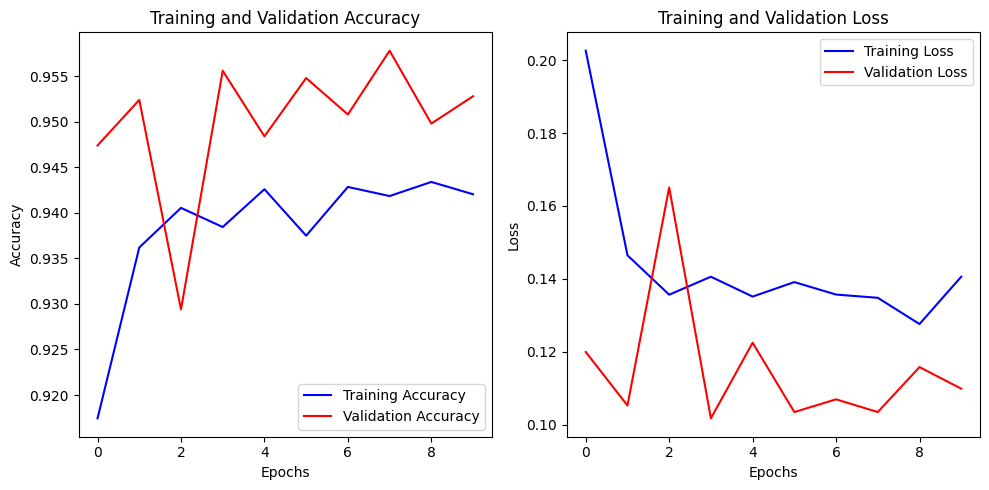

In [ ]:
import matplotlib.pyplot as plt

# Get the accuracy and loss history
train_acc = history['train_acc']
valid_acc = history['valid_acc']
train_loss = history['train_loss']
valid_loss = history['valid_loss']
epochs = range(len(train_acc))

#accuracy plot
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, 'b', label='Training Accuracy')
plt.plot(epochs, valid_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, valid_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/gdrive')

# Define the model path
model_path = '/content/gdrive/My Drive/cat and dog/model.pth'

# Save the model
torch.save(model.state_dict(), model_path)

Mounted at /content/gdrive


In [ ]:
from PIL import Image
import torchvision.transforms as transforms

# Load the image
image_path = '/content/test2.jfif' #image path
image = Image.open(image_path)

#transformation
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# Preprocessing
image = transform(image)
image = image.unsqueeze(0)  # batch dimension

# Move to GPU if available and set to evaluation mode
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# Make the prediction
with torch.no_grad():
    image = image.to(device)
    output = model(image)
    _, predicted = torch.max(output, 1)

# Match the predicted class to the corresponding label
labels = ['Cat', 'Dog']
label = labels[predicted.item()]

print('Image is of:', label)

Image is of: Dog
